In [1]:
import numpy as np
import pandas as pd
import healpy as hp
%config InlineBackend.figure_format = 'retina'
from DS_Planck_Unet import west_val, east_val
from matplotlib import pyplot as plt
from DS_Planck_Unet import load_planck_model, draw_pic_with_mask, draw_pic, val_pix
from DS_healpix_fragmentation import *
from DS_data_transformation import pic2fits, normalize
from DS_detector import *
import os
from astropy.coordinates import SkyCoord
from astropy import units as u
from tqdm.notebook import tqdm
from DS_data_transformation import normalize
import seaborn as sns
from DS_models_stat import stat_orig_cats, do_all_stats, stat_orig_cats_simple
from DS_detector import rematch_cat
from matplotlib.ticker import LinearLocator
from DS_healpix_fragmentation import cut_cat_by_pix

In [2]:
max_pred_unite = np.arange(0.1, 1, 0.05)

In [3]:
def this_ax(ax, ylim=[0, 1.05], yticks=[0.1, 1, 0.1]):
    l = ax.axvline(0.65, c='brown', linestyle='-.')
    l.set_label('max_pred=0.65')
    ax.set_xlabel('max_pred')
    ax.set_xticks(np.arange(0.1, 1, 0.1), minor=True)
    ax.set_xlim(0.1, 1)
    
    
    ax.set_ylim(*ylim)
    ax.set_yticks(np.arange(*yticks), minor=False)
    
    
    #ax.set_yticks(np.arange(*yticks)[::2], minor=False)
    ax.grid(True, axis='both', which='major', linestyle=':')
    ax.grid(True, axis='both', which='minor', alpha=0.2, linestyle=':')
    ax.legend()

In [4]:
def this_ax1(ax, max_pred_unite, ylim=[0, 1.05], yticks=[0.1, 1, 0.1]):
    l = ax.axvline(8.0, c='brown', linestyle='-.')
    l.set_label('s/n=8.0')
    ax.set_xlabel('s/n')
    ax.set_xticks(max_pred_unite, minor=True)
    ax.set_xticks(max_pred_unite[::5], minor=False)
    ax.set_xlim(5.4, 10.1)
    
    ax.set_ylim(*ylim)
    
    ax.set_yticks(np.arange(*yticks), minor=False)
    #ax.set_yticks(np.arange(*yticks)[::2], minor=False)
    
    ax.grid(True, axis='both', which='major', linestyle=':')
    ax.grid(True, axis='both', which='minor', alpha=0.2, linestyle=':')
    #plt.xscale('log')
    ax.set_xscale('log')
    ax.legend()

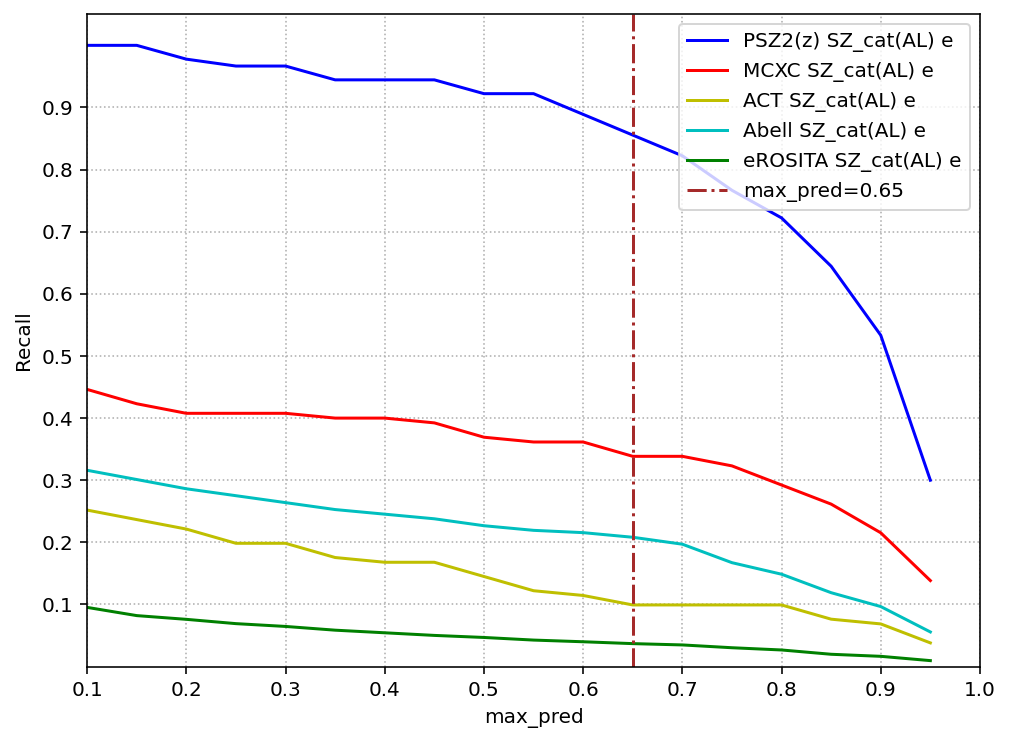

In [12]:
def show_recall(ax, pixname, show_basic, selected):
    base_cat_name = 'SZ_cat(basic)'
    al_cat_name = 'SZ_cat(AL)'
    recalls = {al_cat_name : pd.read_csv('./check/all_found34_recall_max_pred_pix{}.csv'.format(pixname), index_col='max_pred'),
         base_cat_name : pd.read_csv('./check/pz_rot28_recall_max_pred_pix{}.csv'.format(pixname), index_col='max_pred')
    }

    for c, name in zip('brycg', selected):
        for name_cat, st in zip(recalls, ['-', '--']):
            if not show_basic and name_cat == base_cat_name:
                continue
            df = recalls[name_cat]
            s, = ax.plot(df.index, df[name], c=c, linestyle=st)
            if name_cat == al_cat_name:
                s.set_label(name + ' ' + name_cat + ' ' + pixname)
    ax.set_ylabel('Recall')
    this_ax(ax)

_, ax = plt.subplots(1, 1, figsize=(8, 6))
show_recall(ax, 'e', False, ['PSZ2(z)', 'MCXC', 'ACT', 'Abell', 'eROSITA'])

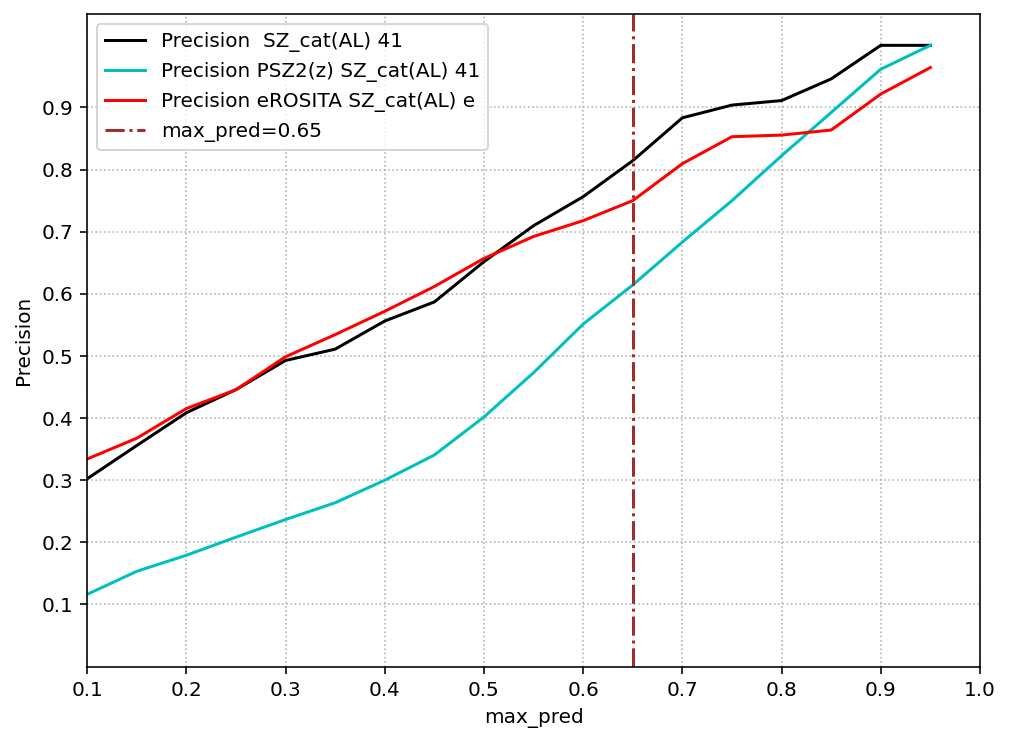

In [15]:
find_precision=0.8

def show_precision(ax, show_basic):

    def plot_precision(ax, pixname, show_basic, selected, colors='kcr'):
        base_cat_name = 'SZ_cat(basic)'
        al_cat_name = 'SZ_cat(AL)'
        recalls = {al_cat_name : pd.read_csv('./check/all_found34_recall_max_pred_pix{}.csv'.format(pixname), index_col='max_pred'),
             base_cat_name : pd.read_csv('./check/pz_rot28_recall_max_pred_pix{}.csv'.format(pixname), index_col='max_pred')
        }
        for name_cat, st in zip(recalls, ['-', '--']):
            if not show_basic and name_cat == base_cat_name:
                continue
            df = recalls[name_cat]
            for prec, c in zip(selected, colors):
                prm = 'precision' if prec == '' else 'precision_' + prec
                s, = ax.plot(df.index, df[prm], c=c, linestyle=st)
                if name_cat == al_cat_name:
                    s.set_label('Precision '+ prec + ' ' + name_cat + ' ' + pixname)
            
            
        if '' in selected:
            text = ''
            for name_cat in recalls:
                df = recalls[name_cat]
                idx = np.abs(df['precision'] - find_precision).argmin()
                mp = np.array(df.index)[idx]
                text += '{} max_pred={:.2f} prec={:.4f}'.format(name_cat, mp, df['precision'][mp]) + '\n'
            #ax.text(s=text, x=0.5, y=0.1)

    plot_precision(ax, pixname='41', show_basic=show_basic, selected=['', 'PSZ2(z)'])            
    plot_precision(ax, pixname='e', show_basic=show_basic, selected=['eROSITA'], colors='r')
    ax.set_ylabel('Precision')
    this_ax(ax)
    
_, ax = plt.subplots(1, 1, figsize=(8, 6))
show_precision(ax, False)        

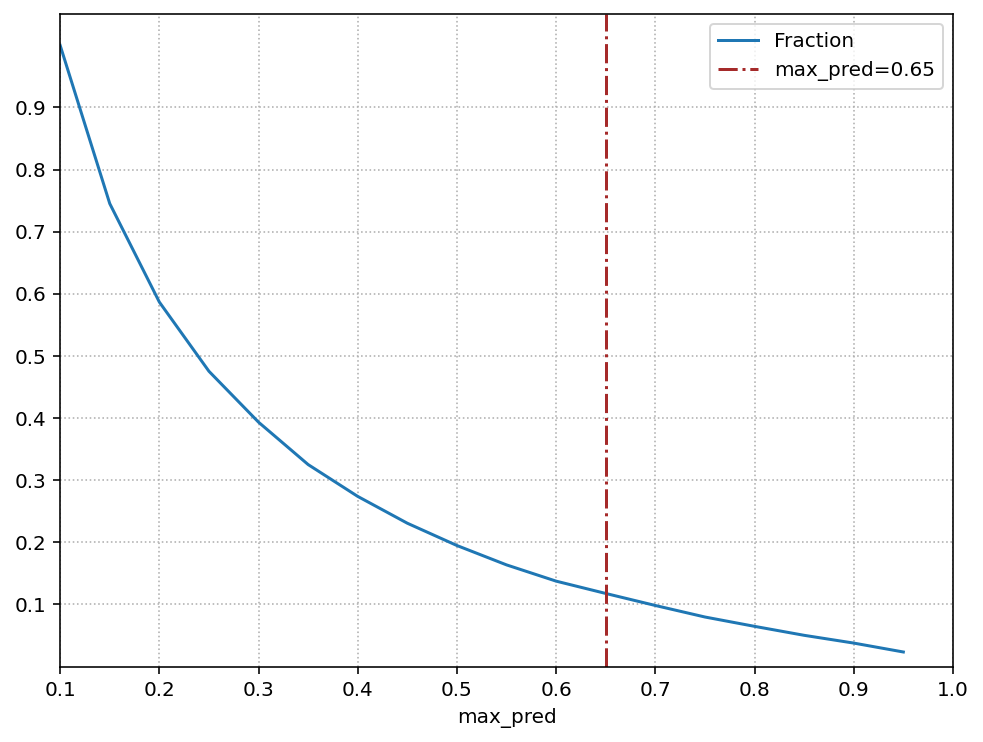

In [8]:
#fraction
df = pd.read_csv('/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv')
fraction = []
for val in max_pred_unite:
    fraction.append(np.count_nonzero(df['max_pred'] >= val) / len(df))

_, ax = plt.subplots(1, 1, figsize=(8, 6))
l, = ax.plot(max_pred_unite, fraction)
l.set_label('Fraction')
this_ax(ax)

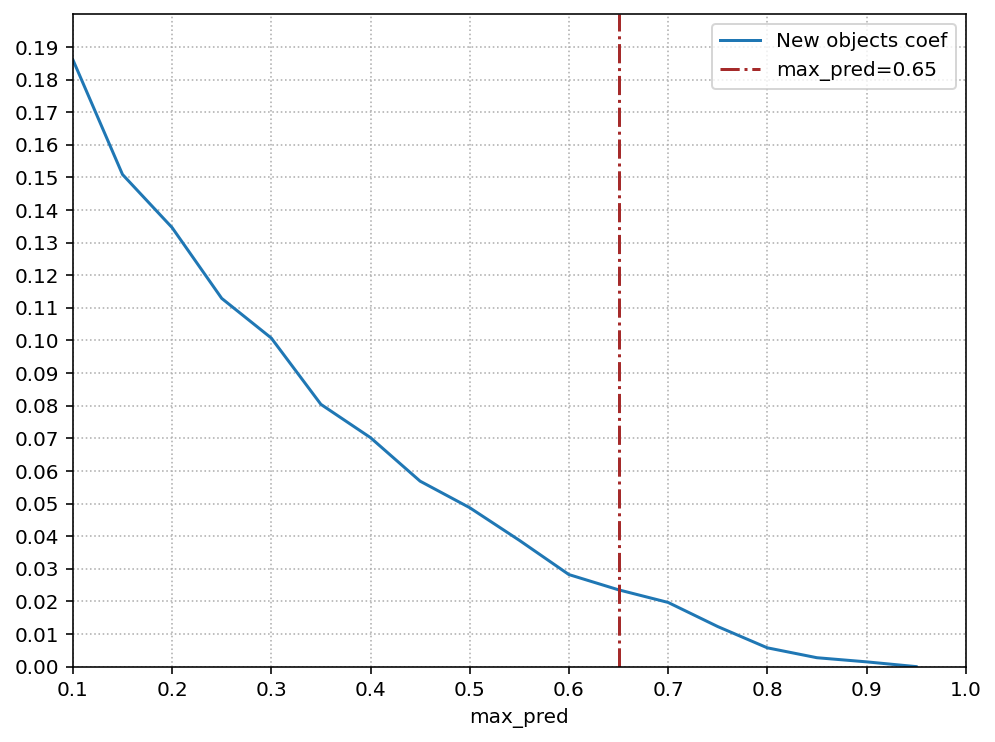

In [9]:
def get_precision_dif(pixname, cat='PSZ2(z)'):
    recall = pd.read_csv('./check/all_found34_recall_max_pred_pix{}.csv'.format(pixname), index_col='max_pred')
    return recall['precision'] - recall['precision_'+cat]

_, ax = plt.subplots(1, 1, figsize=(8, 6))
precision_dif = get_precision_dif(pixname='41')
l, = ax.plot(max_pred_unite, precision_dif * fraction)
l.set_label('New objects coef')
this_ax(ax, ylim=[0, 0.2], yticks=[0, 0.2, 0.01])

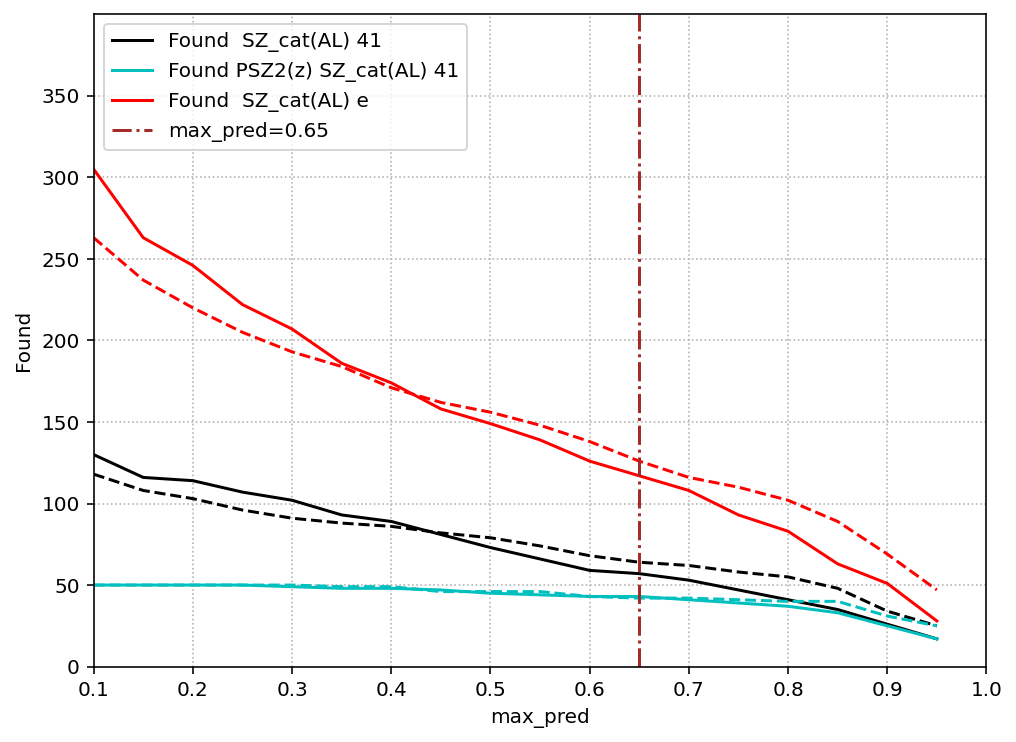

In [10]:
def show_found(ax,show_basic):
    
    def plot_found(ax, pixname, show_basic, selected, colors='kcr'):
        base_cat_name = 'SZ_cat(basic)'
        al_cat_name = 'SZ_cat(AL)'
        recalls = {al_cat_name : pd.read_csv('./check/all_found34_recall_max_pred_pix{}.csv'.format(pixname), index_col='max_pred'),
             base_cat_name : pd.read_csv('./check/pz_rot28_recall_max_pred_pix{}.csv'.format(pixname), index_col='max_pred')
        }
        for name_cat, st in zip(recalls, ['-', '--']):
            df = recalls[name_cat]
            for prec, c in zip(selected, colors):
                prm = 'found' if prec == '' else 'found_' + prec
                s, = ax.plot(df.index, df[prm], c=c, linestyle=st)
                if name_cat == al_cat_name:
                    s.set_label('Found '+ prec + ' ' + name_cat + ' ' + pixname)

    show_basic = True 

    plot_found(ax, pixname='41', show_basic=show_basic, selected=['', 'PSZ2(z)'])            
    plot_found(ax, pixname='e', show_basic=show_basic, selected=['', 'PSZ2(z)'], colors='r')            

    ax.set_ylabel('Found')
    this_ax(ax, ylim=[0, 400], yticks=[0, 400, 50])
_, ax = plt.subplots(1, 1, figsize=(8, 6))
show_found(ax, True)

In [11]:
def cut_max_pred(cat, max_pred):
    df = cat.copy()
    df = df[df['max_pred'] >= max_pred]
    df.index = np.arange(len(df))
    return df

In [4]:
cats_dict = {'pz_rot28' : '/home/rt2122/Data/detected_cats/full_pz_rot28_thr0.1_step8_no_fn.csv',
            'all_found34' : '/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv'}
big_pix = [41]
pixname = '41'
for det_name in cats_dict:
    det_cat = pd.read_csv(cats_dict[det_name])
    cat_d = {max_pred_prm : cut_max_pred(det_cat, max_pred_prm) for max_pred_prm in max_pred_unite}
    recall_df = stat_orig_cats_simple(cat_d, big_pix=big_pix, read_det_files=False, match_dist=400/3600, 
                                     spec_precision=['PSZ2(z)', 'eROSITA'])
    recall_df = recall_df.sort_index()
    recall_df.index.name='max_pred'
    recall_df.to_csv('./check/{}_recall_max_pred_pix{}.csv'.format(det_name, pixname))

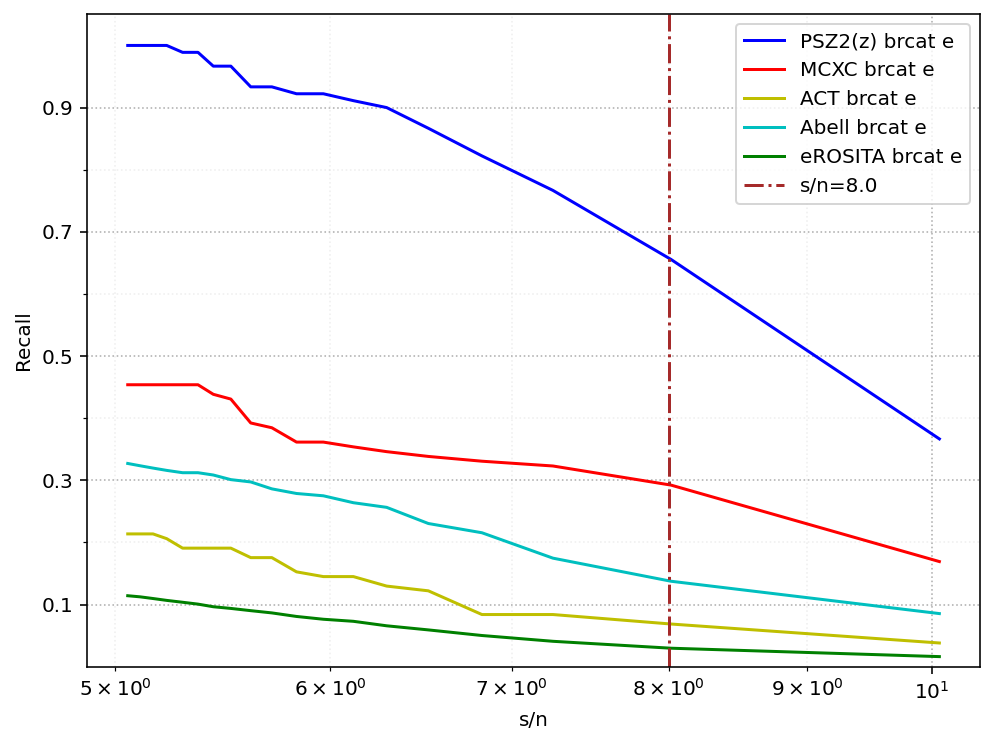

In [77]:
def show_recall_br(ax, pixname, selected):
    det_name='brcat'
    df = pd.read_csv('./check/{}_recall_max_pred_pix{}.csv'.format(det_name, pixname), index_col=['max_pred'])

    for c, name in zip('brycg', selected):
        s, = ax.plot(df.index, df[name], c=c, linestyle='-')
        s.set_label(name + ' ' + det_name + ' ' + pixname)
    ax.set_ylabel('Recall')
    this_ax1(ax, df.index)

_, ax = plt.subplots(1, 1, figsize=(8, 6))
show_recall_br(ax, 'e', ['PSZ2(z)', 'MCXC', 'ACT', 'Abell', 'eROSITA'])

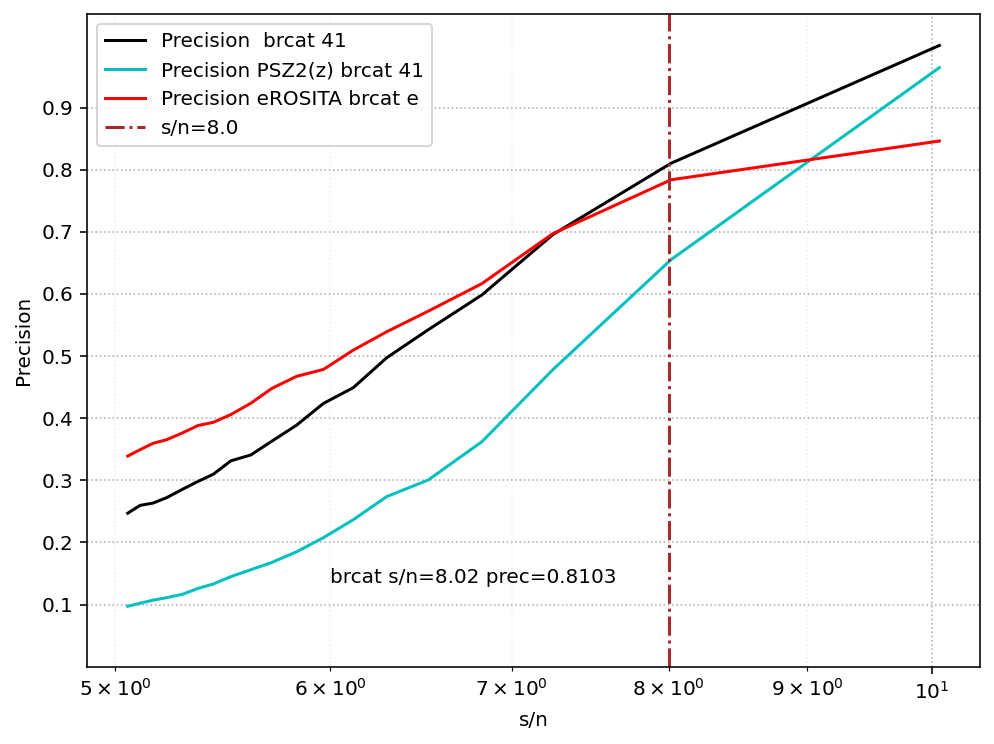

In [96]:
def show_precision_br(ax):
    def plot_precision(ax, pixname, selected, colors='kcr'):
        det_name='brcat'
        df = pd.read_csv('./check/{}_recall_max_pred_pix{}.csv'.format(det_name, pixname), index_col=['max_pred'])
        for prec, c in zip(selected, colors):
            prm = 'precision' if prec == '' else 'precision_' + prec
            s, = ax.plot(df.index, df[prm], c=c, linestyle='-')
            s.set_label('Precision '+ prec + ' ' + det_name+ ' ' + pixname)
            
        if '' in selected:
            idx = np.abs(df['precision'] - find_precision).argmin()
            mp = np.array(df.index)[idx]
            text = '{} s/n={:.2f} prec={:.4f}'.format(det_name, mp, df['precision'][mp]) + '\n'
            ax.text(s=text, x=6, y=0.1)
        return df.index

    index = plot_precision(ax, pixname='41', selected=['', 'PSZ2(z)'])            
    plot_precision(ax, pixname='e', selected=['eROSITA'], colors='r')

    ax.set_ylabel('Precision')
    this_ax1(ax, index)
    
_, ax = plt.subplots(1, 1, figsize=(8, 6))
show_precision_br(ax)

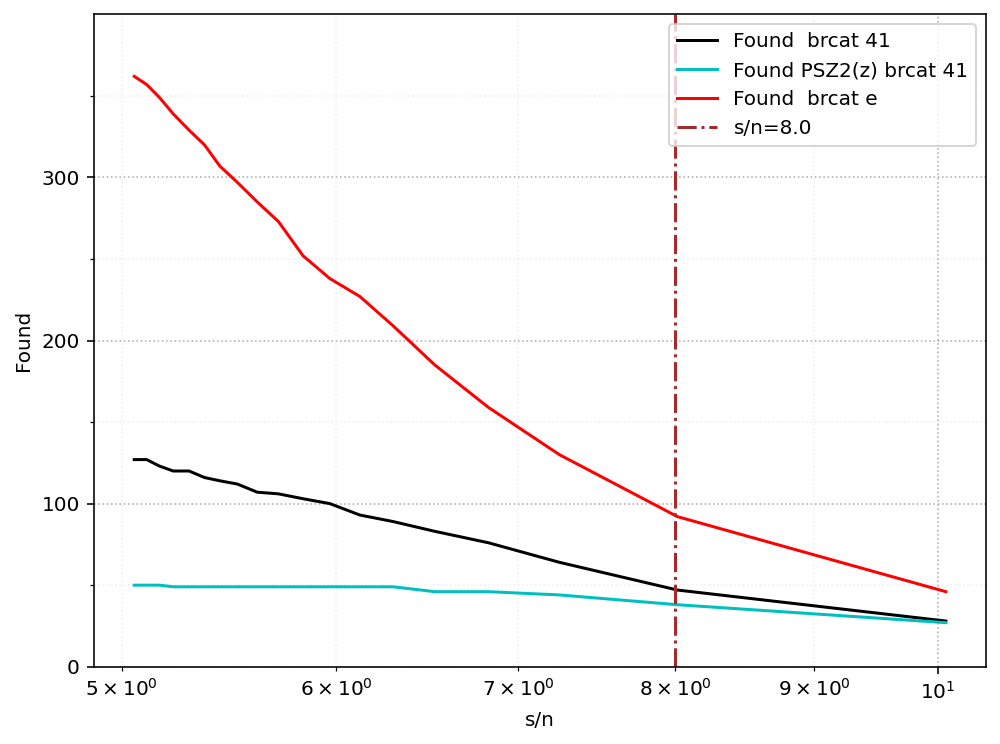

In [71]:
def show_found_br(ax,show_basic):
    
    def plot_found_br(ax, pixname, selected, colors='kcr'):
        det_name='brcat'
        df = pd.read_csv('./check/{}_recall_max_pred_pix{}.csv'.format(det_name, pixname), index_col=['max_pred'])
        for prec, c in zip(selected, colors):
            prm = 'found' if prec == '' else 'found_' + prec
            s, = ax.plot(df.index, df[prm], c=c, linestyle='-')
            s.set_label('Found '+ prec + ' ' + det_name + ' ' + pixname)
        return df.index


    index = plot_found_br(ax, pixname='41', selected=['', 'PSZ2(z)'])            
    plot_found_br(ax, pixname='e', selected=['', 'PSZ2(z)'], colors='r')            

    ax.set_ylabel('Found')
    this_ax1(ax, ylim=[0, 400], yticks=[0, 400, 50], max_pred_unite=index)
_, ax = plt.subplots(1, 1, figsize=(8, 6))
show_found_br(ax, True)

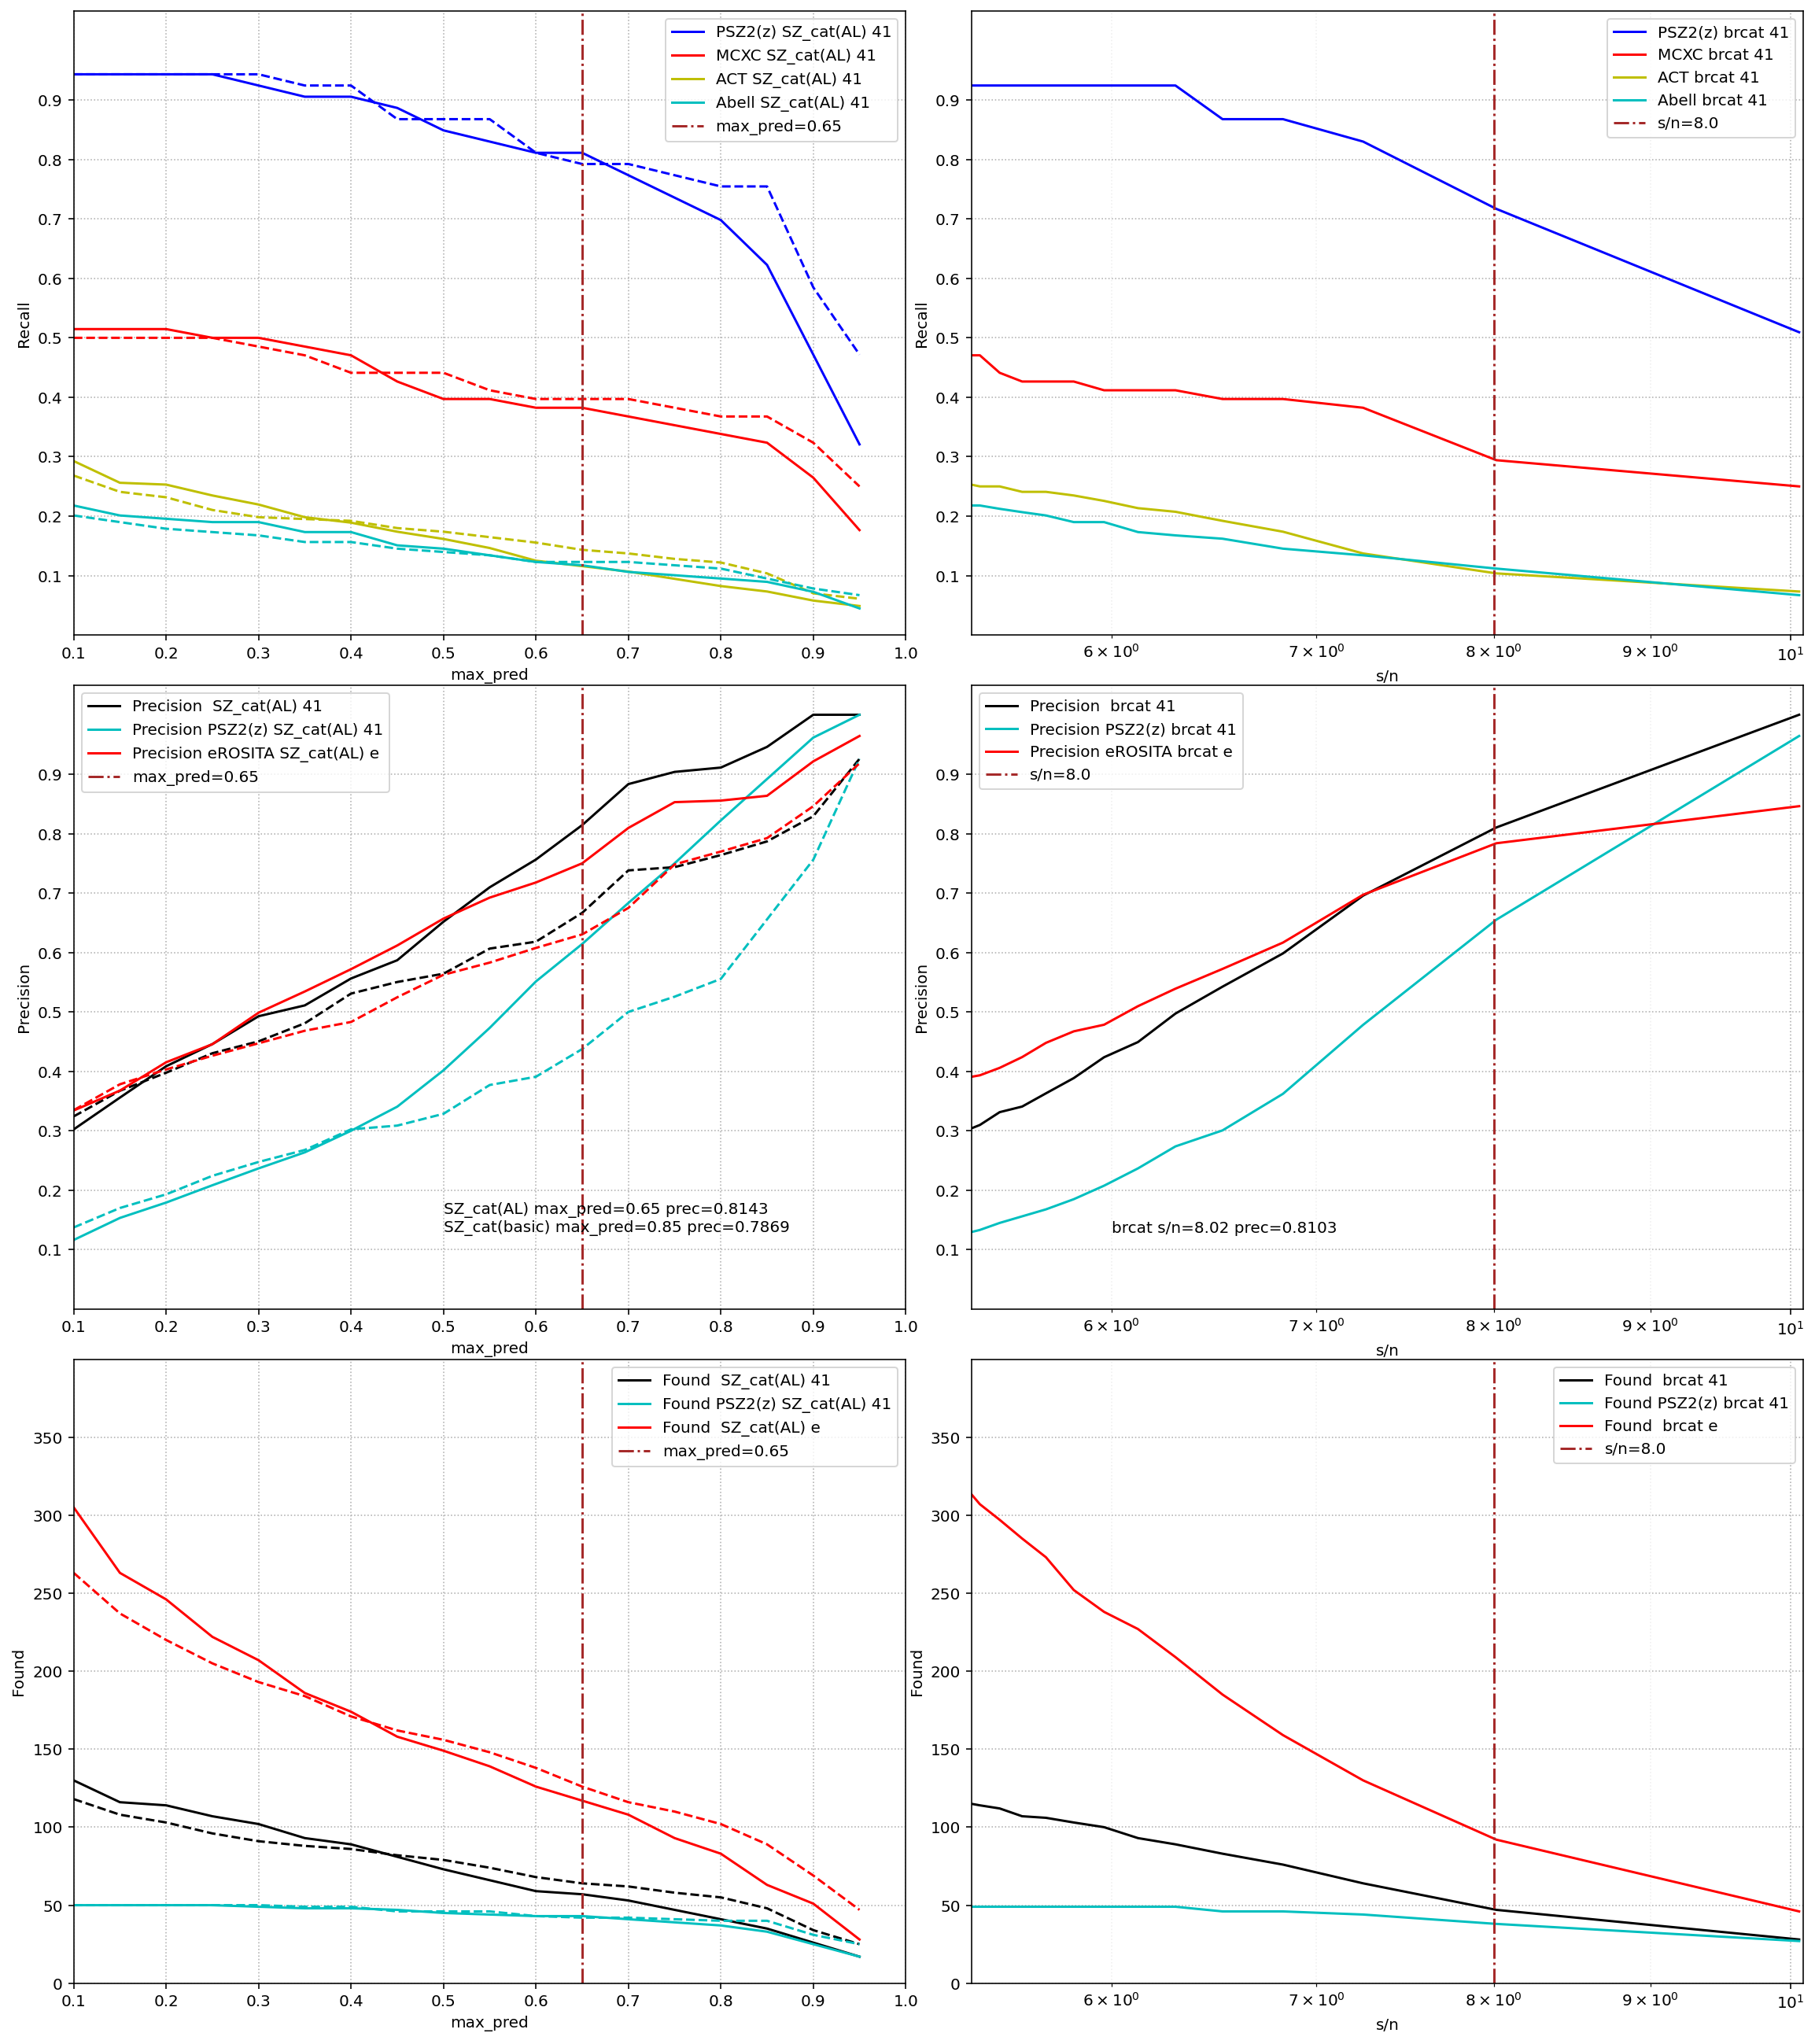

In [107]:
_, ax = plt.subplots(3, 2, figsize=(16, 18), sharey=False)
plt.tight_layout()
show_recall(ax[0][0], '41', True, ['PSZ2(z)', 'MCXC', 'ACT', 'Abell'])
show_recall_br(ax[0][1], '41', ['PSZ2(z)', 'MCXC', 'ACT', 'Abell'])
show_precision(ax[1][0], True)        
show_precision_br(ax[1][1])
show_found(ax[2][0], True)
show_found_br(ax[2][1], True)